# Sandbox NB pour apprendre à coder le training de plusieurs GP avec batchs

https://docs.gpytorch.ai/en/stable/

- On veut apprendre N Processus Gaussiens, pour N processus stochastiques différents.
- Chaque processus stochastique est échantillonné $B$ fois, et les échantillons sont groupés en batchs de taille $B$.
- L'entraînement de chacun des $N$ processus gaussiens se fait dans GPyTorch sur le batch du processus stochastique correspondant.

### Imports

In [143]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import timeit

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.models import ExactGP
from gpytorch.mlls import ExactMarginalLogLikelihood

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### GPU

In [144]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


In [145]:
# parameters
T = 50  # time steps
N = 3  # dimensions, cad le nombre de processus stochastiques à apprendre

In [146]:
# toy functions

def f1(noise=0.1):
    x = torch.linspace(0.0, T-1, steps=T).to(device=device)
    y = torch.sin(2*torch.pi*x / T) + torch.randn(T, device=device) * noise
    return y

def f2(noise=0.1):
    y = torch.randn(T, device=device) * noise
    return y

def f3(noise=1.0, slope=0.25):
    x = torch.linspace(0.0, T-1, steps=T).to(device=device)
    y = slope * x + torch.randn(T, device=device) * noise
    return y

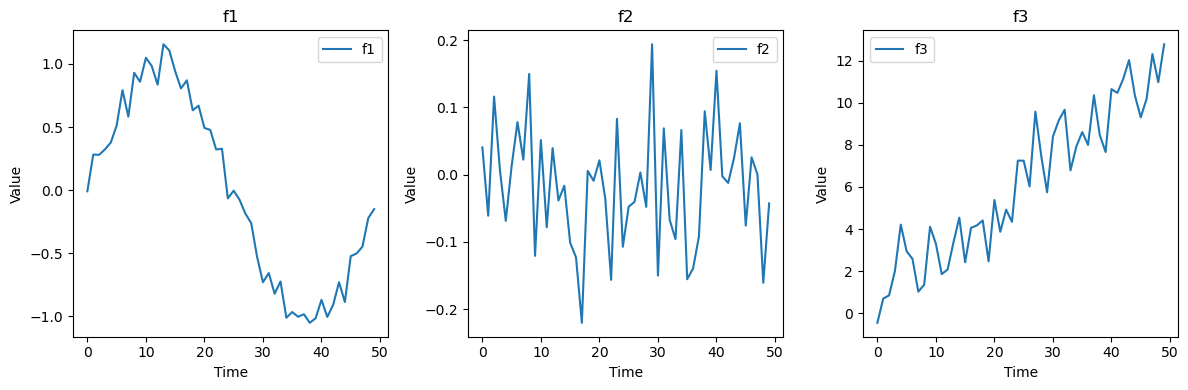

In [147]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(f1().cpu(), label='f1')
ax[0].set_title('f1')
ax[1].plot(f2().cpu(), label='f2')
ax[1].set_title('f2')
ax[2].plot(f3().cpu(), label='f3')
ax[2].set_title('f3')
for a in ax:
    a.legend()
    a.set_xlabel('Time')
    a.set_ylabel('Value')
plt.tight_layout()
plt.show()

In [148]:
# generate batch of data
B = 6 # batch size

# ---- ATTENTION ----

# LA DIMENSION DU BATCH EST SUR LE PREMIER AXE POUR L'ENTRAINEMENT DES PG !
# C'est souvent l'inverse pour les entrainements de LSTM...

#--------------------

big_batch = torch.zeros(B,T,3).to(device=device)
for i in range(B):
    big_batch[i,:,0] = f1()
    big_batch[i,:,1] = f2()
    big_batch[i,:,2] = f3()
    
big_batch.size()  # B x T x N

torch.Size([6, 50, 3])

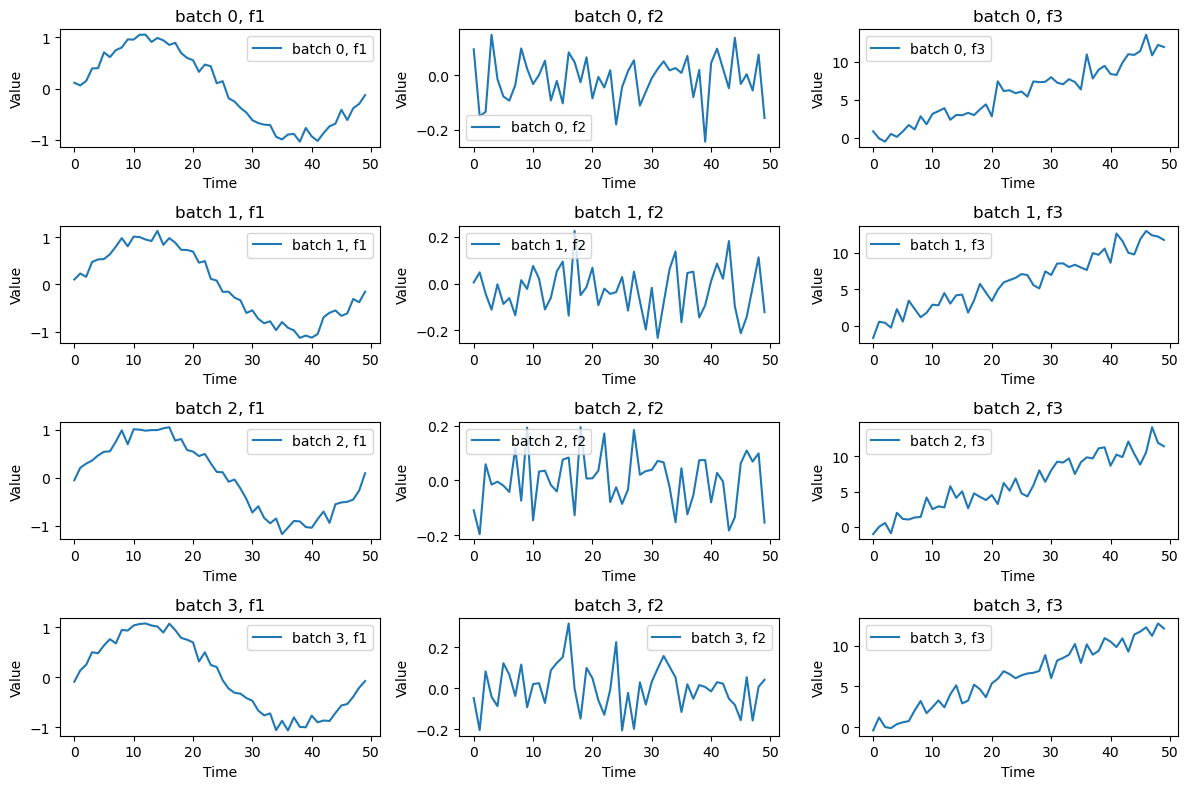

In [149]:
# plot batches
fig, ax = plt.subplots(min(4,B), N, figsize=(12, 8))
for i in range(min(4,B)):
    for j in range(N):
        ax[i,j].plot(big_batch[i,:,j].cpu(), label=f'batch {i}, f{j+1}')
        ax[i,j].set_title(f'batch {i}, f{j+1}')
        ax[i,j].legend()
        ax[i,j].set_xlabel('Time')
        ax[i,j].set_ylabel('Value')
plt.tight_layout()
plt.show()

Gaussian Process

In [150]:
# We will use the simplest form of GP model, exact inference

# Il y a un paramètre batch_shape dans le modèle, pour pouvoir
# permettre l'entrainement sur un batch de données pour chaque fonction.

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        
        """An __init__ method that takes the training data and a likelihood, 
        and constructs whatever objects are necessary for the model"s forward method. 
        This will most commonly include things like a mean module and a kernel module.
        """
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # constant mean as prior mean
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([B]))
        # RBF kernel as prior covariance
        # first, specify a RBF kernel with a SmoothedBoxPrior on the lengthscale (approx Uniform)
        # NB - ici, on peut imaginer d'avoir des kernels différents pour chaque PG, pour apprendre les différents processus stochastiques.
        self.rbf = gpytorch.kernels.RBFKernel(lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(1e-3, 1e+3, sigma=1e-2), batch_shape=torch.Size([B]))
        # then, scale the RBF kernel with a SmoothedBoxPrior on the outputscale (approx Uniform)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.rbf, outputscale_prior=gpytorch.priors.SmoothedBoxPrior(1e-3, 1e+3, sigma=1e-2), batch_shape=torch.Size([B]))

    def forward(self, x):
        """A forward method that takes in some n x d data x and returns a MultivariateNormal with the prior mean and covariance evaluated at x. 
        In other words, we return the vector mu(x) and the n x n matrix representing the prior mean and covariance matrix of the GP.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [151]:
# on créé N processus Gaussiens (3 ici)
# Le PG numéro i sera entrainé sur un batch de données issues de la fonction f_i, cad big_batch[;,;,i], de taille B x T

train_x = torch.linspace(0.0, T-1, steps=T)  # shape (T,)
train_x = train_x.unsqueeze(0)  # shape (1 ,T)
train_x = train_x.repeat(B, 1)  # shape (B, T)
train_x = train_x.unsqueeze(2)  # shape (B, T, 1)
train_x = train_x.to(device=device)  # input data (time steps)

likelihoods = [
    gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([B])).to(device) for _ in range(N) # chaque observation y est gaussienne de moyenne la valeur de la fonction f(x). Le modèle apprend le bruit.
]

models = [
    ExactGPModel(train_x, big_batch[:, :, i], likelihoods[i]).to(device) for i in range(N)
]

In [152]:
# Data in :
print("Training data shape:", big_batch.size())
print("Train_x shape:", train_x.size())

Training data shape: torch.Size([6, 50, 3])
Train_x shape: torch.Size([6, 50, 1])


### Training

Chacun des $N$ processus Gaussiens est entrainé sur le batch de données issues de chacune des $N$ processus stochastiques.
La date d'entraînement est de taille $B \times T$

In [153]:
for i, model in enumerate(models):
    model.train()  # set the model to training mode
    print(f"Model {i} initialized with train_y shape: {model.train_targets.size()}")

Model 0 initialized with train_y shape: torch.Size([6, 50])
Model 1 initialized with train_y shape: torch.Size([6, 50])
Model 2 initialized with train_y shape: torch.Size([6, 50])


In [154]:
n_epochs = 1000  # number of epochs for training

for i, model in enumerate(models):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # optimize the model parameters
    mll = ExactMarginalLogLikelihood(model.likelihood, model)  # Marginal log likelihood
    print(f"Starting training for model {i}") # with likelihood {model.likelihood}")
    
    for iter in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, model.train_targets).sum()  # calcule la loss pour le PG i sur tout le batch
        loss.backward()
        optimizer.step()
        print(f"Model {i}, Iteration {iter+1}, Loss: {loss.item()}")
    print(f"Finished training for model {i}")
    print(f"Model {i} trained with final loss: {loss.item()}")
    # print(f"\nModel {i} parameters:")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(f"{name}: {param.data.cpu().numpy()}")


Starting training for model 0
Model 0, Iteration 1, Loss: 13.843337812257502
Model 0, Iteration 2, Loss: 13.631766473597983
Model 0, Iteration 3, Loss: 13.3875214084773
Model 0, Iteration 4, Loss: 13.154268676609314
Model 0, Iteration 5, Loss: 12.920972922869344
Model 0, Iteration 6, Loss: 12.677810129861706
Model 0, Iteration 7, Loss: 12.431860931768508
Model 0, Iteration 8, Loss: 12.189661815149531
Model 0, Iteration 9, Loss: 11.950846717579626
Model 0, Iteration 10, Loss: 11.71045411692755
Model 0, Iteration 11, Loss: 11.46718033978421
Model 0, Iteration 12, Loss: 11.223902053707334
Model 0, Iteration 13, Loss: 10.982832115909112
Model 0, Iteration 14, Loss: 10.74258711187671
Model 0, Iteration 15, Loss: 10.499884376138244
Model 0, Iteration 16, Loss: 10.253450831365157
Model 0, Iteration 17, Loss: 10.004277313925668
Model 0, Iteration 18, Loss: 9.752985723388337
Model 0, Iteration 19, Loss: 9.498552216077133
Model 0, Iteration 20, Loss: 9.239659634797738
Model 0, Iteration 21, Loss

### Make predictions and plot them

Test data shape: torch.Size([6, 50, 1])


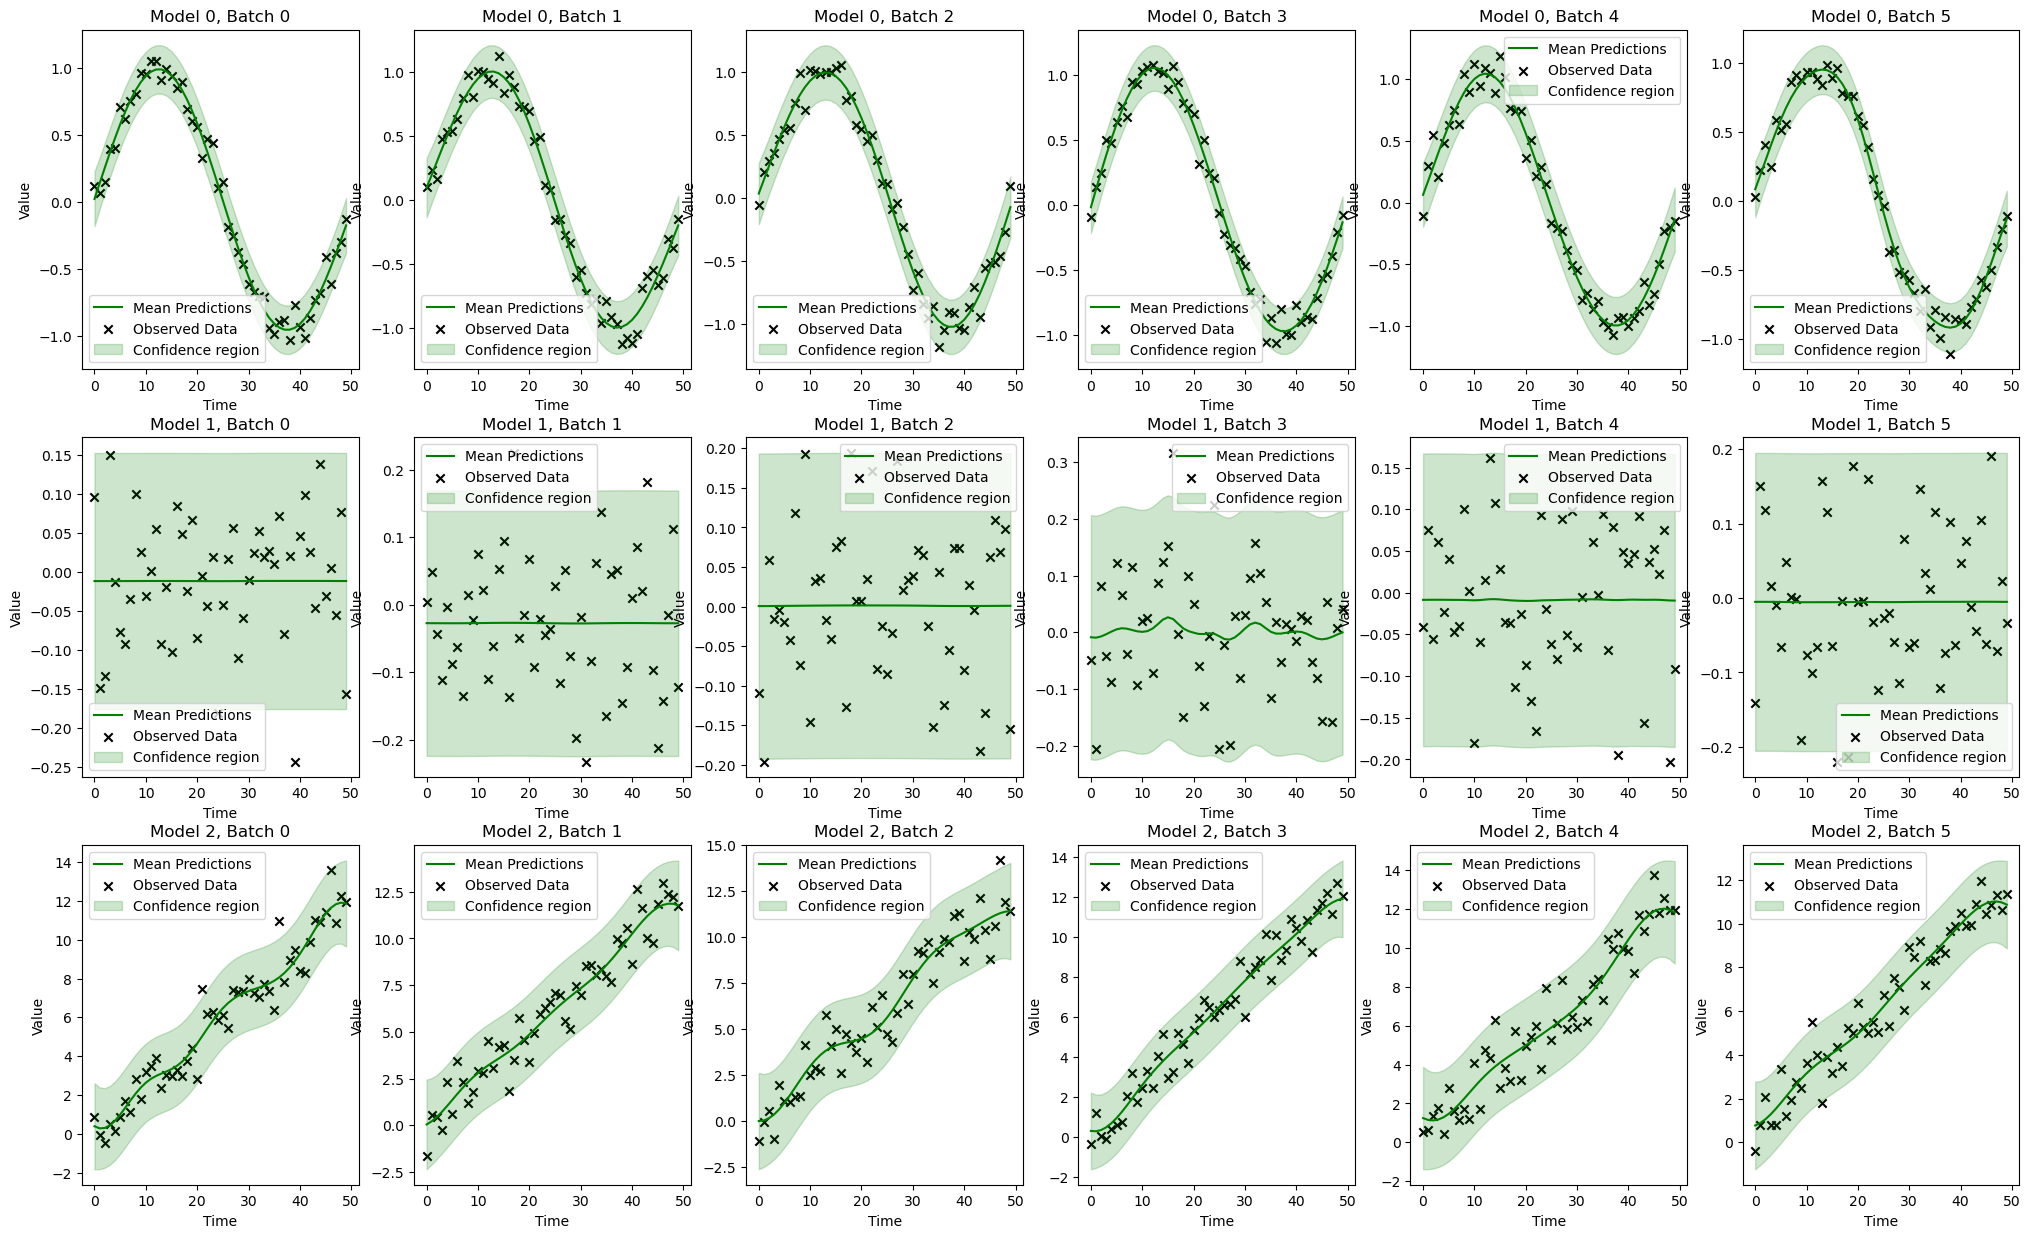

In [159]:
B_test = 6 # number of batches to test

fig, ax = plt.subplots(3, B_test, figsize=(25, 15))

test_x = torch.linspace(0.0, T-1, steps=T)  # shape (T,)
test_x = test_x.unsqueeze(0)  # shape (1 ,T)
test_x = test_x.repeat(B_test, 1)  # shape (B, T)
test_x = test_x.unsqueeze(2)  # shape (B, T, 1)
test_x = test_x.to(device=device)  # input data (time steps)
print("Test data shape:", test_x.size())

for i, model in enumerate(models):
    model.eval()
    model.likelihood.eval()
    for j in range(min(6,B_test)):
        with torch.no_grad():
            observed_pred = model.likelihood(model(test_x))  # predictions du modele sur test_x, c'est une torch.distributions.MultivariateNormal
            # moyenne
            mean = observed_pred.mean.cpu()  # 
            # intervalle de confiance
            # lower et upper sont les bornes de l'intervalle de confiance à 95%
            lower, upper = observed_pred.confidence_region()
            lower = lower.cpu()
            upper = upper.cpu()
            # display
            ax[i,j].plot(test_x[j,:,0].cpu(), mean[j,:], 'g', label='Mean Predictions')
            ax[i,j].scatter(test_x[j,:,0].cpu(), model.train_targets[j,:].cpu(), c='black', marker='x', label='Observed Data')
            ax[i,j].fill_between(test_x[j,:,0].cpu(), lower[j,:], upper[j,:], alpha=0.2, color='g', label='Confidence region')
            ax[i,j].set_title(f'Model {i}, Batch {j}')
            ax[i,j].set_xlabel('Time')
            ax[i,j].set_ylabel('Value')
            ax[i,j].legend()

In [160]:
for i, model in enumerate(models):
    print(f"Model {i} parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data.cpu().numpy()}")
    print("\n")

Model 0 parameters:
likelihood.noise_covar.raw_noise: [[-4.90743317]
 [-4.63664516]
 [-4.55174651]
 [-4.96347804]
 [-4.41580759]
 [-4.9952018 ]]
mean_module.raw_constant: [-0.00157912  0.00744792  0.06501939  0.02776598  0.05364778 -0.00886451]
rbf.raw_lengthscale: [[[14.9640717 ]]

 [[14.58827862]]

 [[15.22198694]]

 [[17.10791591]]

 [[12.97847567]]

 [[ 8.28623619]]]
covar_module.raw_outputscale: [ 0.57556061  0.35584341  0.9161454   1.88749732  0.2495639  -0.9109761 ]


Model 1 parameters:
likelihood.noise_covar.raw_noise: [[-5.01008158]
 [-4.64653412]
 [-4.68457508]
 [-4.51344507]
 [-4.87992602]
 [-4.60840208]]
mean_module.raw_constant: [-0.01195422 -0.02743196  0.00093008  0.00114005 -0.00876226 -0.00521731]
rbf.raw_lengthscale: [[[4.58012359]]

 [[3.86662516]]

 [[4.81637961]]

 [[1.51971981]]

 [[1.46810814]]

 [[3.6079666 ]]]
covar_module.raw_outputscale: [-11.90850115 -11.12830154 -11.12511618  -7.37012018 -10.45568773
 -11.22814004]


Model 2 parameters:
likelihood.noise_co